In [ ]:
import tensorflow as tf
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
# import data
drive.mount('/content/drive')
with open('/content/drive/My Drive/Colab Notebooks/projects/data.csv', 'r') as f: 
  data = np.genfromtxt(f, dtype='f4', delimiter=',')
samplenum = 5000
X = data[:samplenum,:-1]
y = data[:samplenum,-1]
print('# of samples = ', samplenum)
# partition into train, validate, test set at 60/20/20 division
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
TSSytest = np.sum((y_test - np.mean(y_test))**2)
nytest = len(y_test)

Mounted at /content/drive
# of samples =  5000


In [ ]:
MSError = np.zeros(6)
AdjustedR2 = np.zeros(6)
for index, i in enumerate(np.array([5, 10, 15, 20, 25, 30])):
  net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(i, input_dim=X.shape[1], activation = 'relu'),
    tf.keras.layers.Dense(i, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
  history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val,y_val))
  MSError[index] = net.evaluate(X_test, y_test,verbose=0)[0]
  AdjustedR2[index] = 1 - (MSError[index]*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))

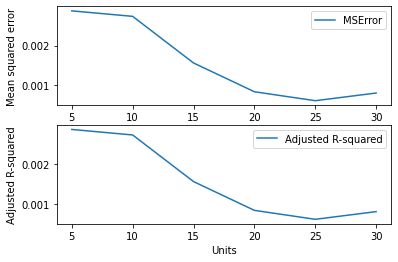

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.array([5, 10, 15, 20, 25, 30]), MSError , label='MSError')
axs[0].plot(np.array([5, 10, 15, 20, 25, 30]), MSError , label='MSError')
axs[0].set_xlabel('Units')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(np.array([5, 10, 15, 20, 25, 30]), MSError , label='Adjusted R-squared')
axs[1].set_xlabel('Units')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

All features

In [ ]:
MSError = np.zeros(6)
AdjustedR2 = np.zeros(6)
for index, i in enumerate(np.array([5, 10, 15, 20, 25, 30])):
  net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(i, input_dim=X.shape[1], activation = 'softplus'),
    tf.keras.layers.Dense(i, activation = 'softplus'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
  history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val,y_val))
  MSError[index] = net.evaluate(X_test, y_test,verbose=0)[0]
  AdjustedR2[index] = 1 - (MSError[index]*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))


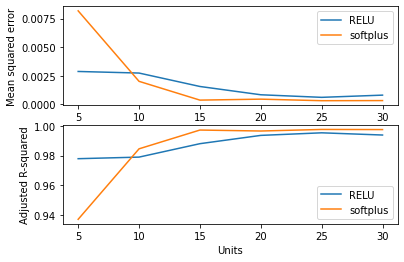

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.array([5, 10, 15, 20, 25, 30]), MSError , label='RELU')
axs[0].plot(np.array([5, 10, 15, 20, 25, 30]), np.array([0.00817239, 0.00201184, 0.00037045, 0.00045527, 0.00031929,
       0.00032971]) , label='softplus')
axs[0].set_xlabel('Units')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(np.array([5, 10, 15, 20, 25, 30]), AdjustedR2 , label='RELU')
axs[1].plot(np.array([5, 10, 15, 20, 25, 30]), np.array([0.93723382, 0.98454852, 0.99715483, 0.99650343, 0.99754778,
       0.99746771]) , label='softplus')
axs[1].set_xlabel('Units')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

In [ ]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/projects/MSError_1.csv', MSError, delimiter=",")
np.savetxt('/content/drive/My Drive/Colab Notebooks/projects/AdjustedR2_1.csv', AdjustedR2, delimiter=",")

In [ ]:
MSError

array([0.00817239, 0.00201184, 0.00037045, 0.00045527, 0.00031929,
       0.00032971])

In [ ]:
AdjustedR2

array([0.93723382, 0.98454852, 0.99715483, 0.99650343, 0.99754778,
       0.99746771])

In [ ]:
net = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, input_dim=X.shape[1], activation = 'softplus'),
    tf.keras.layers.Dense(10, activation = 'softplus'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
history = net.fit(X_train, y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val,y_val))
MSError = net.evaluate(X_test, y_test,verbose=0)[0]
AdjustedR2 = 1 - (MSError*nytest/(nytest-X.shape[1]-1))/(TSSytest/(nytest-1))
print('MSError =', MSError)
print('Adjusted R2=', AdjustedR2)

MSError = 0.001311713014729321
Adjusted R2= 0.9899256808334489


Subset selection: Forward stepwise selection



In [ ]:
MSError_F = np.ones((X.shape[1],X.shape[1],6))*np.inf
AdjustedR2_F = np.zeros((X.shape[1],X.shape[1],6))

for num in range(X.shape[1]):
  # print('Now selecting the #',num,'significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_F[:num],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(10, input_dim=num+1, activation = 'softplus'),
      tf.keras.layers.Dense(10, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.append(np.argmin(MSError_F[:num,:],axis=1),nextfeature)

    for e, size in enumerate(np.array([2, 5, 10, 25, 50])):
      history = net.fit(X_train[:,feature], y_train, epochs= 30, verbose=0, batch_size=size, validation_data=(X_val[:,feature],y_val))

      MSError_F[num,nextfeature,e] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
      
      # print('Feature', feature, '. MSError = ', MSError_F[num,nextfeature])
      AdjustedR2_F[num,nextfeature,e] = 1 - (MSError_F[num,nextfeature,e]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  # print('Feature', np.argmin(MSError_F[:num+1,:],axis=1),
  #       'MSE =', MSError_F[num,np.argmin(MSError_F[num,:])],
  #       'Adjusted R2 =', AdjustedR2_F[num,np.argmin(MSError_F[num,:])])

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.array([2, 5, 10, 25, 50]), MSError_F[0,0,:] , label='Feature')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(np.array([2, 5, 10, 25, 50]), AdjustedR2_F[0,0,:] , label='Feature')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

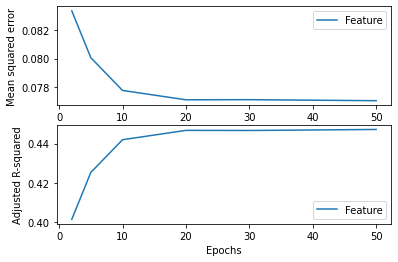

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(np.array([2, 5, 10, 20, 30, 50]), MSError_F[0,0,:] , label='Feature')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(np.array([2, 5, 10, 20, 30, 50]), AdjustedR2_F[0,0,:] , label='Feature')

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()

In [ ]:
MSError_F = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_F = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]):
  # print('Now selecting the #',num,'significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_F[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(20, input_dim=num+1, activation = 'softplus'),
      tf.keras.layers.Dense(20, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.append(np.argmin(MSError_F[:num,:],axis=1),nextfeature)
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val[:,feature],y_val))
    MSError_F[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_F[num,nextfeature])
    AdjustedR2_F[num,nextfeature] = 1 - (MSError_F[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_F[:num+1,:],axis=1),
        'MSE =', MSError_F[num,np.argmin(MSError_F[num,:])],
        'Adjusted R2 =', AdjustedR2_F[num,np.argmin(MSError_F[num,:])])

Feature [2] MSE = 0.037849608808755875 Adjusted R2 = 0.7283097340256384
Feature [2 0] MSE = 0.0018246930558234453 Adjusted R2 = 0.9868889375518641
Feature [2 0 7] MSE = 0.0006380907143466175 Adjusted R2 = 0.995410490097261
Feature [2 0 7 3] MSE = 0.0004439342301338911 Adjusted R2 = 0.996803764451591
Feature [2 0 7 3 9] MSE = 0.00031785049941390753 Adjusted R2 = 0.9977092392212934
Feature [ 2  0  7  3  9 10] MSE = 0.00035334820859134197 Adjusted R2 = 0.9974508413195062
Feature [ 2  0  7  3  9 10  8] MSE = 0.00031617580680176616 Adjusted R2 = 0.9977167146598904
Feature [ 2  0  7  3  9 10  8  6] MSE = 0.0003061263123527169 Adjusted R2 = 0.9977870569860798
Feature [ 2  0  7  3  9 10  8  6  1] MSE = 0.00037726672599092126 Adjusted R2 = 0.9972700384294414
Feature [ 2  0  7  3  9 10  8  6  1  4] MSE = 0.00034001070889644325 Adjusted R2 = 0.997537141112736
Feature [ 2  0  7  3  9 10  8  6  1  4  5] MSE = 0.001453856471925974 Adjusted R2 = 0.9894583688929964


In [ ]:
MSError_B = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_B = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]-1):
  # print('Now selecting the #',num,'least significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_B[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(20, input_dim=X.shape[1]-num-1, activation = 'softplus'),
      tf.keras.layers.Dense(20, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.array(list(set(range(X.shape[1]))-set(np.append(np.argmin(MSError_B[:num,:],axis=1),nextfeature))))
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val[:,feature],y_val))
    MSError_B[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_B[num,nextfeature])
    AdjustedR2_B[num,nextfeature] = 1 - (MSError_B[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_B[:num+1,:],axis=1),
        'MSE = ', MSError_B[num,np.argmin(MSError_B[num,:])],
        'Adjusted R2 =', AdjustedR2_B[num,np.argmin(MSError_B[num,:])])

Feature [6] MSE =  0.0002873082412406802 Adjusted R2 = 0.9979376576155987
Feature [6 8] MSE =  0.0002802487288136035 Adjusted R2 = 0.9979863141514353
Feature [6 8 5] MSE =  0.0003965339856222272 Adjusted R2 = 0.9971479029346959
Feature [6 8 5 3] MSE =  0.0003002159937750548 Adjusted R2 = 0.9978385063228502
Feature [6 8 5 3 7] MSE =  0.0004533961764536798 Adjusted R2 = 0.9967323563116912
Feature [ 6  8  5  3  7 10] MSE =  0.000399084878154099 Adjusted R2 = 0.9971208834326456
Feature [ 6  8  5  3  7 10  4] MSE =  0.0003959239984396845 Adjusted R2 = 0.9971408076077064
Feature [ 6  8  5  3  7 10  4  9] MSE =  0.0006533480482175946 Adjusted R2 = 0.9952770410754642
Feature [ 6  8  5  3  7 10  4  9  1] MSE =  0.001442454056814313 Adjusted R2 = 0.989562174792764
Feature [ 6  8  5  3  7 10  4  9  1  0] MSE =  0.03766411915421486 Adjusted R2 = 0.7271809147100037


In [ ]:
MSError_F = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_F = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]):
  # print('Now selecting the #',num,'significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_F[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(20, input_dim=num+1, activation = 'softplus'),
      tf.keras.layers.Dense(20, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.append(np.argmin(MSError_F[:num,:],axis=1),nextfeature)
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val[:,feature],y_val))
    MSError_F[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_F[num,nextfeature])
    AdjustedR2_F[num,nextfeature] = 1 - (MSError_F[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_F[:num+1,:],axis=1),
        'MSE =', MSError_F[num,np.argmin(MSError_F[num,:])],
        'Adjusted R2 =', AdjustedR2_F[num,np.argmin(MSError_F[num,:])])

Feature [2] MSE = 0.04240180924534798 Adjusted R2 = 0.5877010053829937
Feature [2 0] MSE = 0.006540941074490547 Adjusted R2 = 0.9363345947932329
Feature [2 0 1] MSE = 0.0007550938753411174 Adjusted R2 = 0.9926430121571269
Feature [2 0 1 8] MSE = 0.0005856649950146675 Adjusted R2 = 0.9942880471272133
Feature [2 0 1 8 5] MSE = 0.0006280964589677751 Adjusted R2 = 0.9938680530388351
Feature [ 2  0  1  8  5 10] MSE = 0.0006618701736442745 Adjusted R2 = 0.9935318215778818
Feature [ 2  0  1  8  5 10  7] MSE = 0.0006155699375085533 Adjusted R2 = 0.9939782300641414
Feature [ 2  0  1  8  5 10  7  4] MSE = 0.0006568334065377712 Adjusted R2 = 0.9935680892783237
Feature [ 2  0  1  8  5 10  7  4  6] MSE = 0.000670551264192909 Adjusted R2 = 0.9934271273150888
Feature [ 2  0  1  8  5 10  7  4  6  9] MSE = 0.0012552320258691907 Adjusted R2 = 0.9876835329644889
Feature [ 2  0  1  8  5 10  7  4  6  9  3] MSE = 0.0015298936050385237 Adjusted R2 = 0.9849733312163297


Subset selection: Backward stepwise selection

In [ ]:
MSError_B = np.ones((X.shape[1],X.shape[1]))*np.inf
AdjustedR2_B = np.zeros((X.shape[1],X.shape[1]))

for num in range(X.shape[1]-1):
  # print('Now selecting the #',num,'least significant feature.')
  for nextfeature in range(X.shape[1]):
    if nextfeature in np.argmin(MSError_B[:num,:],axis=1):
      continue
    net = tf.keras.models.Sequential([
      tf.keras.layers.Normalization(),
      tf.keras.layers.Dense(10, input_dim=X.shape[1]-num-1, activation = 'softplus'),
      tf.keras.layers.Dense(10, activation = 'softplus'),
      tf.keras.layers.Dense(1, activation='sigmoid')
      ])
    net.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MeanSquaredError'])
    feature = np.array(list(set(range(X.shape[1]))-set(np.append(np.argmin(MSError_B[:num,:],axis=1),nextfeature))))
    history = net.fit(X_train[:,feature], y_train, epochs=50, verbose=0, batch_size=50, validation_data=(X_val[:,feature],y_val))
    MSError_B[num,nextfeature] = net.evaluate(X_test[:,feature], y_test,verbose=0)[0]
    # print('Feature', feature, '. MSError = ', MSError_B[num,nextfeature])
    AdjustedR2_B[num,nextfeature] = 1 - (MSError_B[num,nextfeature]*nytest/(nytest-(num+1)-1))/(TSSytest/(nytest-1))
  print('Feature', np.argmin(MSError_B[:num+1,:],axis=1),
        'MSE = ', MSError_B[num,np.argmin(MSError_B[num,:])],
        'Adjusted R2 =', AdjustedR2_B[num,np.argmin(MSError_B[num,:])])

Feature [9] MSE =  0.0006097974255681038 Adjusted R2 = 0.9940705627906821
Feature [9 4] MSE =  0.0006096090655773878 Adjusted R2 = 0.9940664488892791
Feature [9 4 5] MSE =  0.0006546511431224644 Adjusted R2 = 0.9936216400919698
Feature [9 4 5 8] MSE =  0.0007438044995069504 Adjusted R2 = 0.9927457227529127
Feature [9 4 5 8 1] MSE =  0.0009681872907094657 Adjusted R2 = 0.9905478322153557
Feature [9 4 5 8 1 3] MSE =  0.0010206218576058745 Adjusted R2 = 0.9900258924795475
Feature [9 4 5 8 1 3 6] MSE =  0.0008246878860518336 Adjusted R2 = 0.9919325483326992
Feature [ 9  4  5  8  1  3  6 10] MSE =  0.000820251414552331 Adjusted R2 = 0.9919678508808826
Feature [ 9  4  5  8  1  3  6 10  7] MSE =  0.006753735709935427 Adjusted R2 = 0.9337985813472822
Feature [ 9  4  5  8  1  3  6 10  7  0] MSE =  0.04214305430650711 Adjusted R2 = 0.5864879731837376


In [ ]:
# Save data
np.savetxt('/content/drive/My Drive/ECE539/project2/MSError_F.csv', MSError_F, delimiter=",")
np.savetxt('/content/drive/My Drive/ECE539/project2/AdjustedR2_F.csv', AdjustedR2_F, delimiter=",")
np.savetxt('/content/drive/My Drive/ECE539/project2/MSError_B.csv', MSError_B, delimiter=",")
np.savetxt('/content/drive/My Drive/ECE539/project2/AdjustedR2_B.csv', AdjustedR2_B, delimiter=",")

Compare two forward and backward stepwise:

In [ ]:
back1 = np.array(list(set(range(X.shape[1]))-set(np.argmin(MSError_B[:-1,:],axis=1))))
for num in range(1,X.shape[1]):
  print(num,'predictor(s)')
  print('Forward:',np.argmin(MSError_F[:num,:],axis=1))
  print('Backward:',np.concatenate((back1,np.flip(np.argmin(MSError_B[X.shape[1]-num:-1,:],axis=1)))))

1 predictor(s)
Forward: [2]
Backward: [2]
2 predictor(s)
Forward: [2 0]
Backward: [2 0]
3 predictor(s)
Forward: [2 0 1]
Backward: [2 0 7]
4 predictor(s)
Forward: [2 0 1 8]
Backward: [ 2  0  7 10]
5 predictor(s)
Forward: [2 0 1 8 5]
Backward: [ 2  0  7 10  6]
6 predictor(s)
Forward: [ 2  0  1  8  5 10]
Backward: [ 2  0  7 10  6  3]
7 predictor(s)
Forward: [ 2  0  1  8  5 10  7]
Backward: [ 2  0  7 10  6  3  1]
8 predictor(s)
Forward: [ 2  0  1  8  5 10  7  4]
Backward: [ 2  0  7 10  6  3  1  8]
9 predictor(s)
Forward: [ 2  0  1  8  5 10  7  4  6]
Backward: [ 2  0  7 10  6  3  1  8  5]
10 predictor(s)
Forward: [ 2  0  1  8  5 10  7  4  6  9]
Backward: [ 2  0  7 10  6  3  1  8  5  4]


Dongzheng Chen’s previous theoretical studies on this electronic problem indicate that Features [0,1,2] are the three major features.
Such result is consistent with the three most impactful features resulted from forward stepwise selection.
The two most impact features resulted from forward and backward stepwise selection methods -- [2,0], which is a subset of the results from Dongzheng Chen's previous study.

Plot mean squared error and adjusted R-squared versus number of predictors.

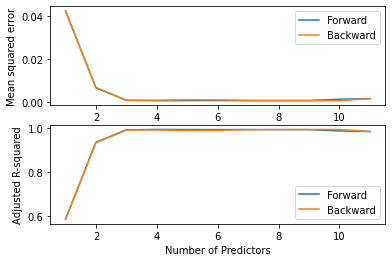

In [ ]:
MAMA = np.zeros((4,X.shape[1]))
for num in range(X.shape[1]-1):
  MAMA[0,num] = MSError_F[num,np.argmin(MSError_F[num,:])]
  MAMA[1,num] = AdjustedR2_F[num,np.argmin(MSError_F[num,:])]
  MAMA[2,num] = MSError_B[X.shape[1]-2-num,np.argmin(MSError_B[X.shape[1]-2-num,:])]
  MAMA[3,num] = AdjustedR2_B[X.shape[1]-2-num,np.argmin(MSError_B[X.shape[1]-2-num,:])]
MAMA[0,-1] = MSError
MAMA[1,-1] = AdjustedR2
MAMA[2,-1] = MSError
MAMA[3,-1] = AdjustedR2

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[0], label='Forward')
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[2], label='Backward')
axs[0].set_xlabel('Number of Predictors')
axs[0].set_ylabel('Mean squared error')
axs[0].legend()

axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[1], label='Forward')
axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[3], label='Backward')
axs[1].set_xlabel('Number of Predictors')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].legend()
fig.savefig('/content/drive/My Drive/ECE539/project2/FvsB.pdf')

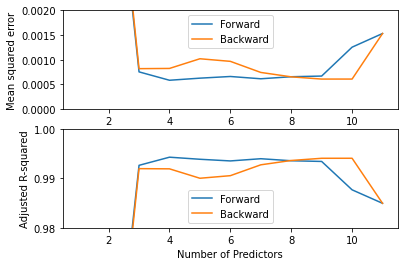

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[0], label='Forward')
axs[0].plot(list(range(1,X.shape[1]+1)), MAMA[2], label='Backward')
axs[0].set_xlabel('Number of Predictors')
axs[0].set_ylabel('Mean squared error')
axs[0].set_ylim(0,0.002)
axs[0].legend()

axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[1], label='Forward')
axs[1].plot(list(range(1,X.shape[1]+1)), MAMA[3], label='Backward')
axs[1].set_xlabel('Number of Predictors')
axs[1].set_ylabel('Adjusted R-squared')
axs[1].set_ylim(0.98,1)
axs[1].legend()
fig.savefig('/content/drive/My Drive/ECE539/project2/FvsBzoom.pdf')

Except for results of number of predictors $\geq8$, the forward stepwise selection has better performance than the backward stepwise selection, with smaller mean squared error and larger adjusted R-squared.

In [ ]:
print('In the forward stepwise selection,',np.argmax(MAMA[1,:])+1,
      'predictors lead to largest value of adjusted R-squared, which is',MAMA[1,np.argmax(MAMA[1,:])])
print('The features are',np.argmin(MSError_F[:np.argmax(MAMA[1,:])+1,:],axis=1))

In the forward stepwise selection, 4 predictors lead to largest value of adjusted R-squared, which is 0.9942880471272133
The features are [2 0 1 8]
